In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from pathlib import Path
from sklearn.preprocessing import RobustScaler
import mdshare
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from deeptime.markov import TransitionCountEstimator as TCE

In [3]:
def FES_plot(x, y, ax, cbar=False, cax=None, levels=15, nbins=60, weights=None): pyemma.plots.plot_free_energy(x, y, levels=levels, nbins=nbins, ax=ax, cbar=cbar, cax=cax, weights=weights)

In [4]:
fake_trj_fname = sorted([str(p) for p in Path('CLN_testset').glob('hallucinated_*.dcd')])
fake_top_fname = '../midway3_c2f/chig_new/AA.pdb'

real_trj_fname = sorted([str(p) for p in Path('CLN_testset').glob('AA_*.dcd')])
real_top_fname = '../midway3_c2f/chig_new/AA.pdb'

ref_trj_fname = sorted([str(p) for p in Path('/project2/andrewferguson/Kirill/midway3_c2f/chig_new/AA_xtc/').glob('*.xtc')])
ref_top_fname = '../midway3_c2f/chig_new/AA.pdb'

# REF

In [5]:
pdb = ref_top_fname
files = ref_trj_fname
num_timescales=8
lagtime = 20

In [6]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Ca())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data = [d for d in data if d.shape[0] > lagtime]

tica_estimator = dt.decomposition.TICA(lagtime=lagtime, dim=2)
tica = tica_estimator.fit(data).fetch_model()

projected_data = [tica.transform(traj) for traj in data]

In [7]:
cluster = dt.clustering.KMeans(150, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

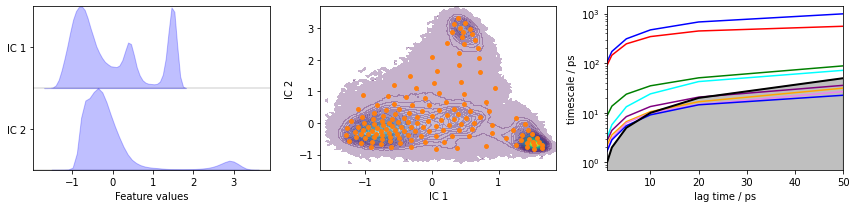

In [8]:
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales)#, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()

In [9]:
counts = TCE(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs).submodel_largest()

fraction of states used = 1.000000
fraction of counts used = 1.000000


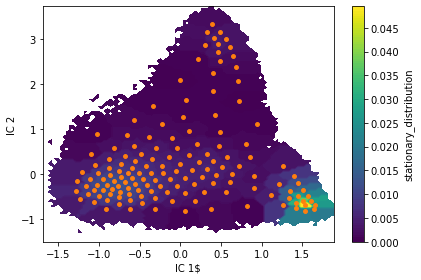

In [10]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(counts).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('IC 1$')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999607, max=1.000000000000026)


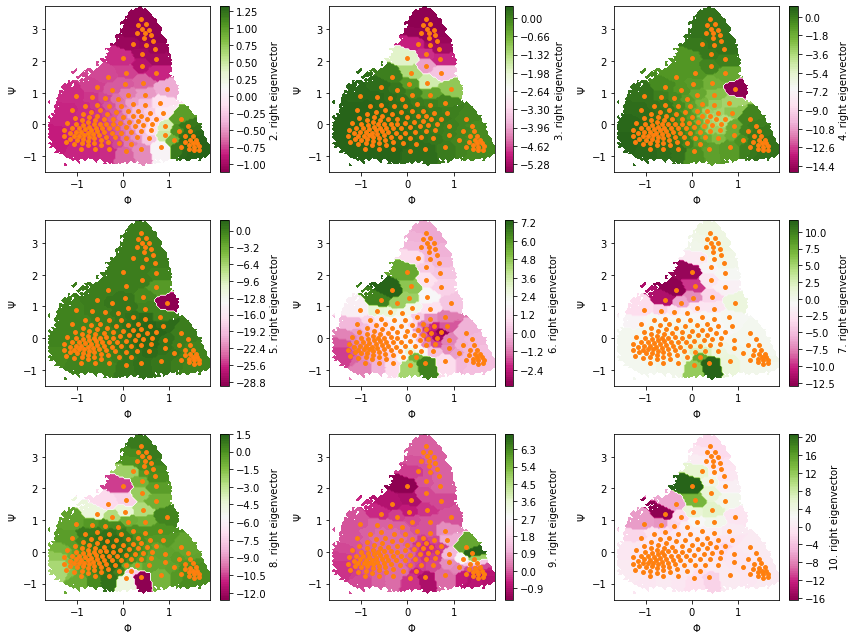

In [11]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

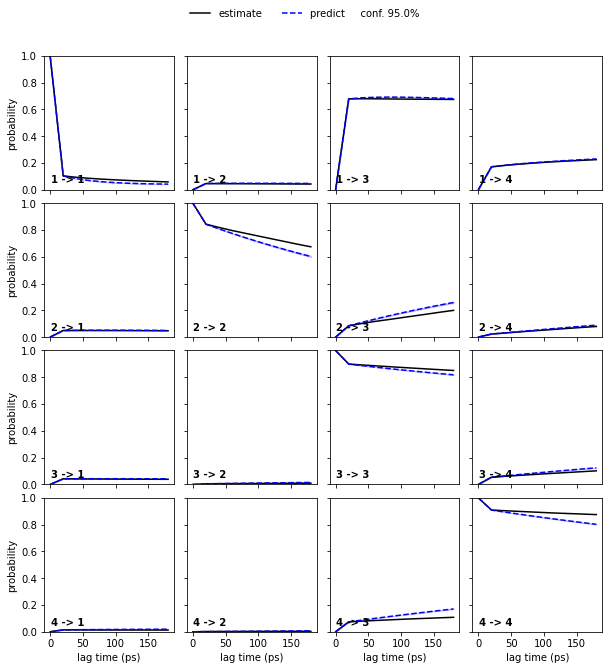

In [12]:
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [13]:
stats = bayesian_msm.gather_stats('timescales', k=num_timescales)
sample_mean = stats.mean
sample_conf_l, sample_conf_r = stats.L, stats.R

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
ref_sample_mean = sample_mean
ref_sample_conf_l = sample_conf_l
ref_sample_conf_r = sample_conf_r

Mean of ITS #0: 692.731447
Confidence interval of ITS #0: [683.541029, 702.501150]
Mean of ITS #1: 448.308951
Confidence interval of ITS #1: [439.295935, 459.133521]
Mean of ITS #2: 51.266427
Confidence interval of ITS #2: [50.324261, 52.957844]
Mean of ITS #3: 42.724150
Confidence interval of ITS #3: [39.305851, 45.898789]
Mean of ITS #4: 20.796107
Confidence interval of ITS #4: [20.636632, 20.951078]
Mean of ITS #5: 16.773465
Confidence interval of ITS #5: [16.483938, 17.102627]
Mean of ITS #6: 14.732734
Confidence interval of ITS #6: [14.588931, 14.948225]
Mean of ITS #7: 14.503610
Confidence interval of ITS #7: [14.296915, 14.692155]


In [14]:
evec_ref = eigvec
dtrajs_ref = dtrajs
projected_data_ref = projected_data

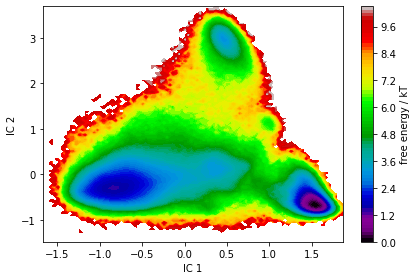

In [15]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_ref).T[0]
IC_1 = np.concatenate(projected_data_ref).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

plt.tight_layout()
plt.show()

# REAL

In [16]:
pdb = real_top_fname
files = real_trj_fname

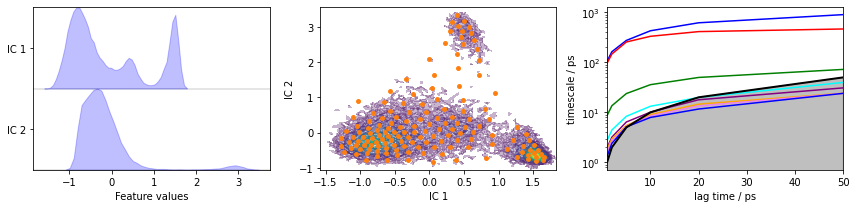

In [17]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Ca())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data = [d for d in data if d.shape[0] > lagtime]

#tica_estimator = dt.decomposition.TICA(lagtime=lagtime, dim=2)
#tica = tica_estimator.fit(data).fetch_model()

projected_data = [tica.transform(traj) for traj in data]

#cluster = dt.clustering.KMeans(150, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales)#, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()

In [18]:
counts_effective = TCE(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs).submodel_largest()
counts_sliding = TCE(lagtime=lagtime, count_mode='sliding').fit_fetch(dtrajs).submodel(counts_effective.state_symbols)

In [19]:
proj_dtrajs = counts_sliding.transform_discrete_trajectories_to_submodel(dtrajs)
proj_dtrajs_cc = np.concatenate(proj_dtrajs)
proj_dtrajs_cc = proj_dtrajs_cc[proj_dtrajs_cc >= 0]  # only use this for plotting

fraction of states used = 1.000000
fraction of counts used = 1.000000


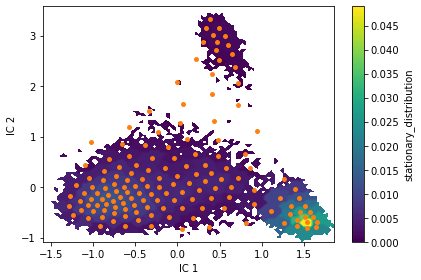

In [20]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(counts_sliding).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[proj_dtrajs_cc],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999823, max=1.0000000000000207)


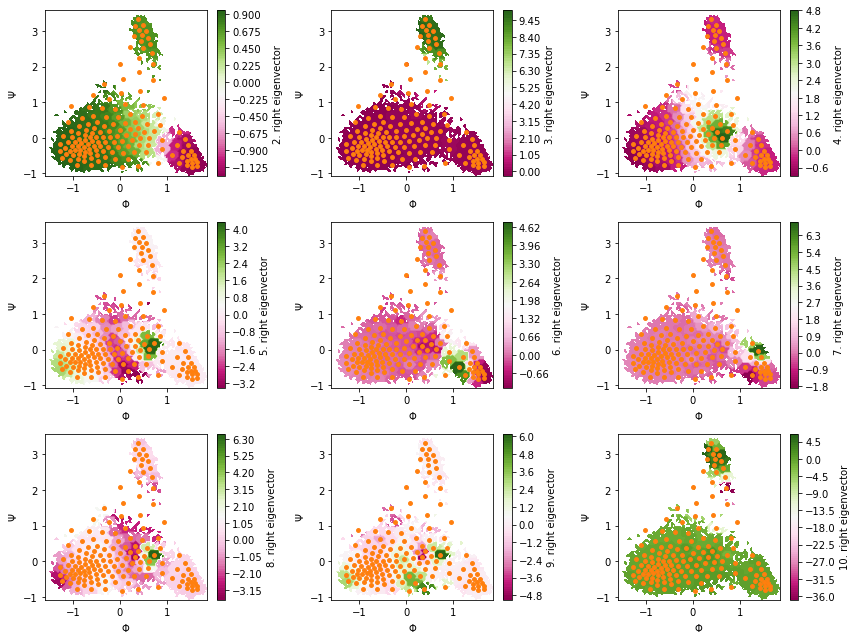

In [21]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[proj_dtrajs_cc, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

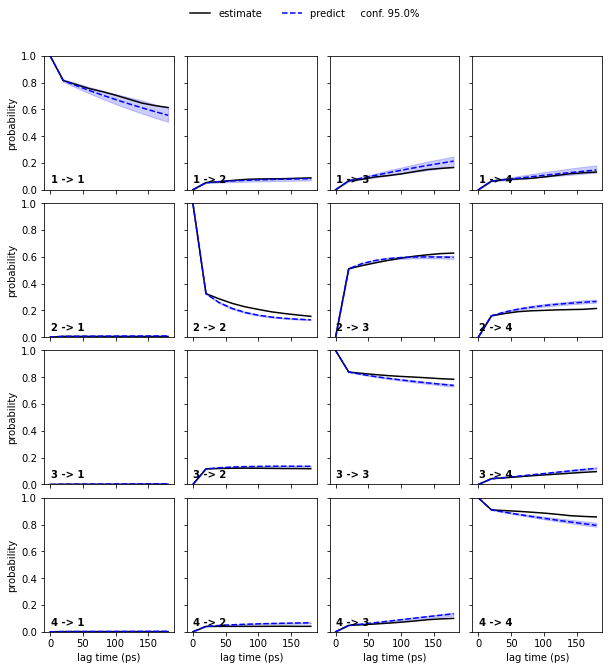

In [22]:
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts_effective).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [23]:
stats = bayesian_msm.gather_stats('timescales', k=num_timescales)
sample_mean = stats.mean
sample_conf_l, sample_conf_r = stats.L, stats.R

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 634.635685
Confidence interval of ITS #0: [589.080726, 696.747222]
Mean of ITS #1: 420.562751
Confidence interval of ITS #1: [338.478886, 531.563390]
Mean of ITS #2: 50.275214
Confidence interval of ITS #2: [48.070376, 52.537255]
Mean of ITS #3: 20.113011
Confidence interval of ITS #3: [19.482171, 20.750712]
Mean of ITS #4: 18.042300
Confidence interval of ITS #4: [16.985014, 19.067688]
Mean of ITS #5: 14.920883
Confidence interval of ITS #5: [13.876688, 16.205098]
Mean of ITS #6: 13.910804
Confidence interval of ITS #6: [13.270795, 15.188841]
Mean of ITS #7: 12.844214
Confidence interval of ITS #7: [11.847539, 14.057706]


In [24]:
evec_real = eigvec
dtrajs_real = dtrajs
projected_data_real = projected_data

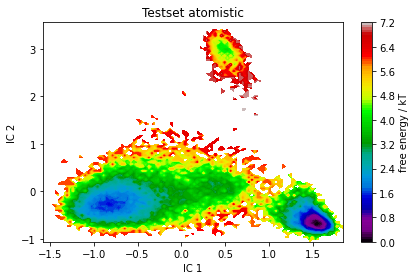

In [25]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_real).T[0]
IC_1 = np.concatenate(projected_data_real).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_title('Testset atomistic')

plt.tight_layout()
plt.show()

# Fake

In [26]:
pdb = fake_top_fname
files = fake_trj_fname

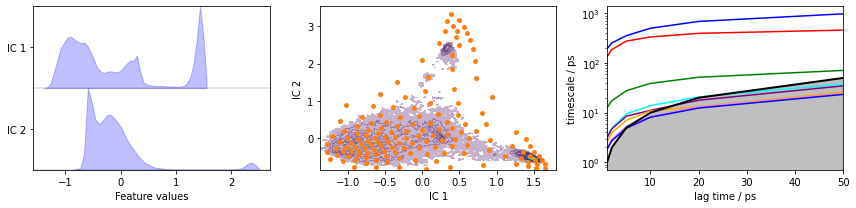

In [27]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Ca())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data = [d for d in data if d.shape[0] > lagtime]

#tica_estimator = dt.decomposition.TICA(lagtime=lagtime, dim=2)
#tica = tica_estimator.fit(data).fetch_model()

projected_data = [tica.transform(traj) for traj in data]

#cluster = dt.clustering.KMeans(150, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales)#, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()

In [28]:
counts_effective = TCE(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs).submodel_largest()
counts_sliding = TCE(lagtime=lagtime, count_mode='sliding').fit_fetch(dtrajs).submodel(counts_effective.state_symbols)

In [29]:
proj_dtrajs = counts_sliding.transform_discrete_trajectories_to_submodel(dtrajs)
proj_dtrajs_cc = np.concatenate(proj_dtrajs)
proj_dtrajs_cc = proj_dtrajs_cc[proj_dtrajs_cc >= 0]  # only use this for plotting

fraction of states used = 0.846667
fraction of counts used = 1.000000


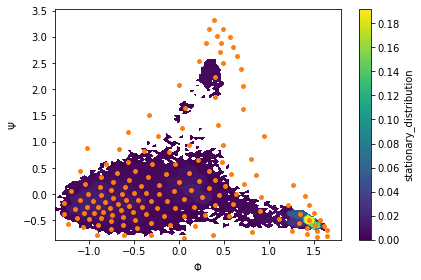

In [30]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(counts_sliding).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[proj_dtrajs_cc],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999664, max=1.000000000000022)


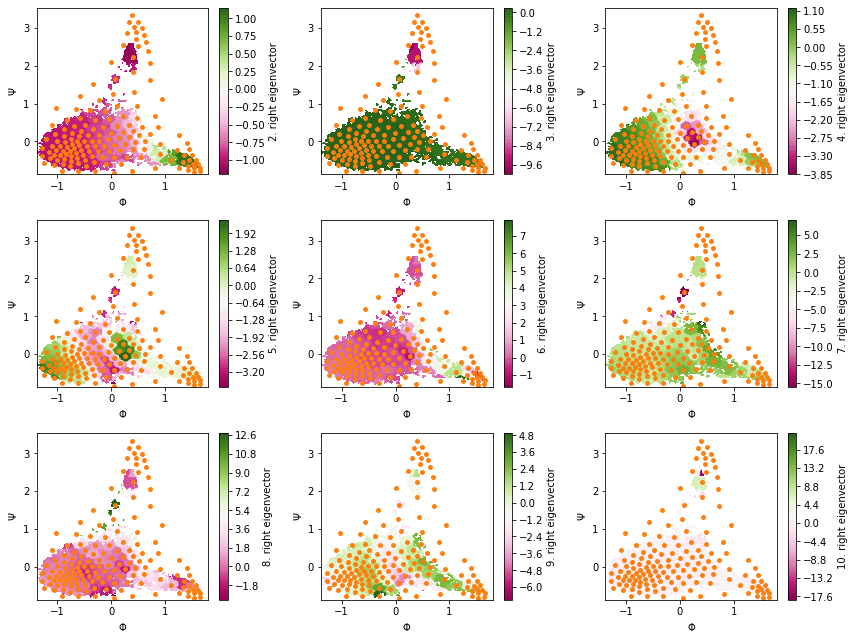

In [31]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[proj_dtrajs_cc, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

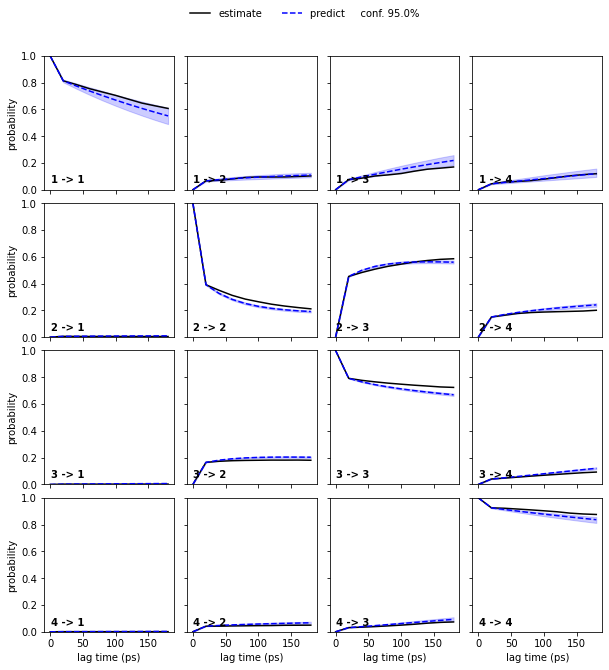

In [32]:
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts_effective).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [33]:
stats = bayesian_msm.gather_stats('timescales', k=num_timescales)
sample_mean = stats.mean
sample_conf_l, sample_conf_r = stats.L, stats.R

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 735.363513
Confidence interval of ITS #0: [651.997534, 842.335416]
Mean of ITS #1: 397.837184
Confidence interval of ITS #1: [319.425035, 529.136564]
Mean of ITS #2: 52.024000
Confidence interval of ITS #2: [49.880154, 54.353036]
Mean of ITS #3: 20.992320
Confidence interval of ITS #3: [20.245428, 21.637525]
Mean of ITS #4: 17.809610
Confidence interval of ITS #4: [16.281820, 19.910644]
Mean of ITS #5: 14.732642
Confidence interval of ITS #5: [13.369567, 17.728614]
Mean of ITS #6: 13.696361
Confidence interval of ITS #6: [12.872419, 15.123251]
Mean of ITS #7: 13.078049
Confidence interval of ITS #7: [12.353277, 14.424919]


In [34]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

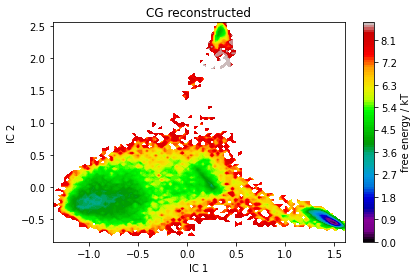

In [35]:
ax = plt.gca()

IC_0 = np.concatenate(projected_data_fake).T[0]
IC_1 = np.concatenate(projected_data_fake).T[1]


FES_plot(IC_0, IC_1, ax, cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_title('CG reconstructed')

plt.tight_layout()
plt.show()

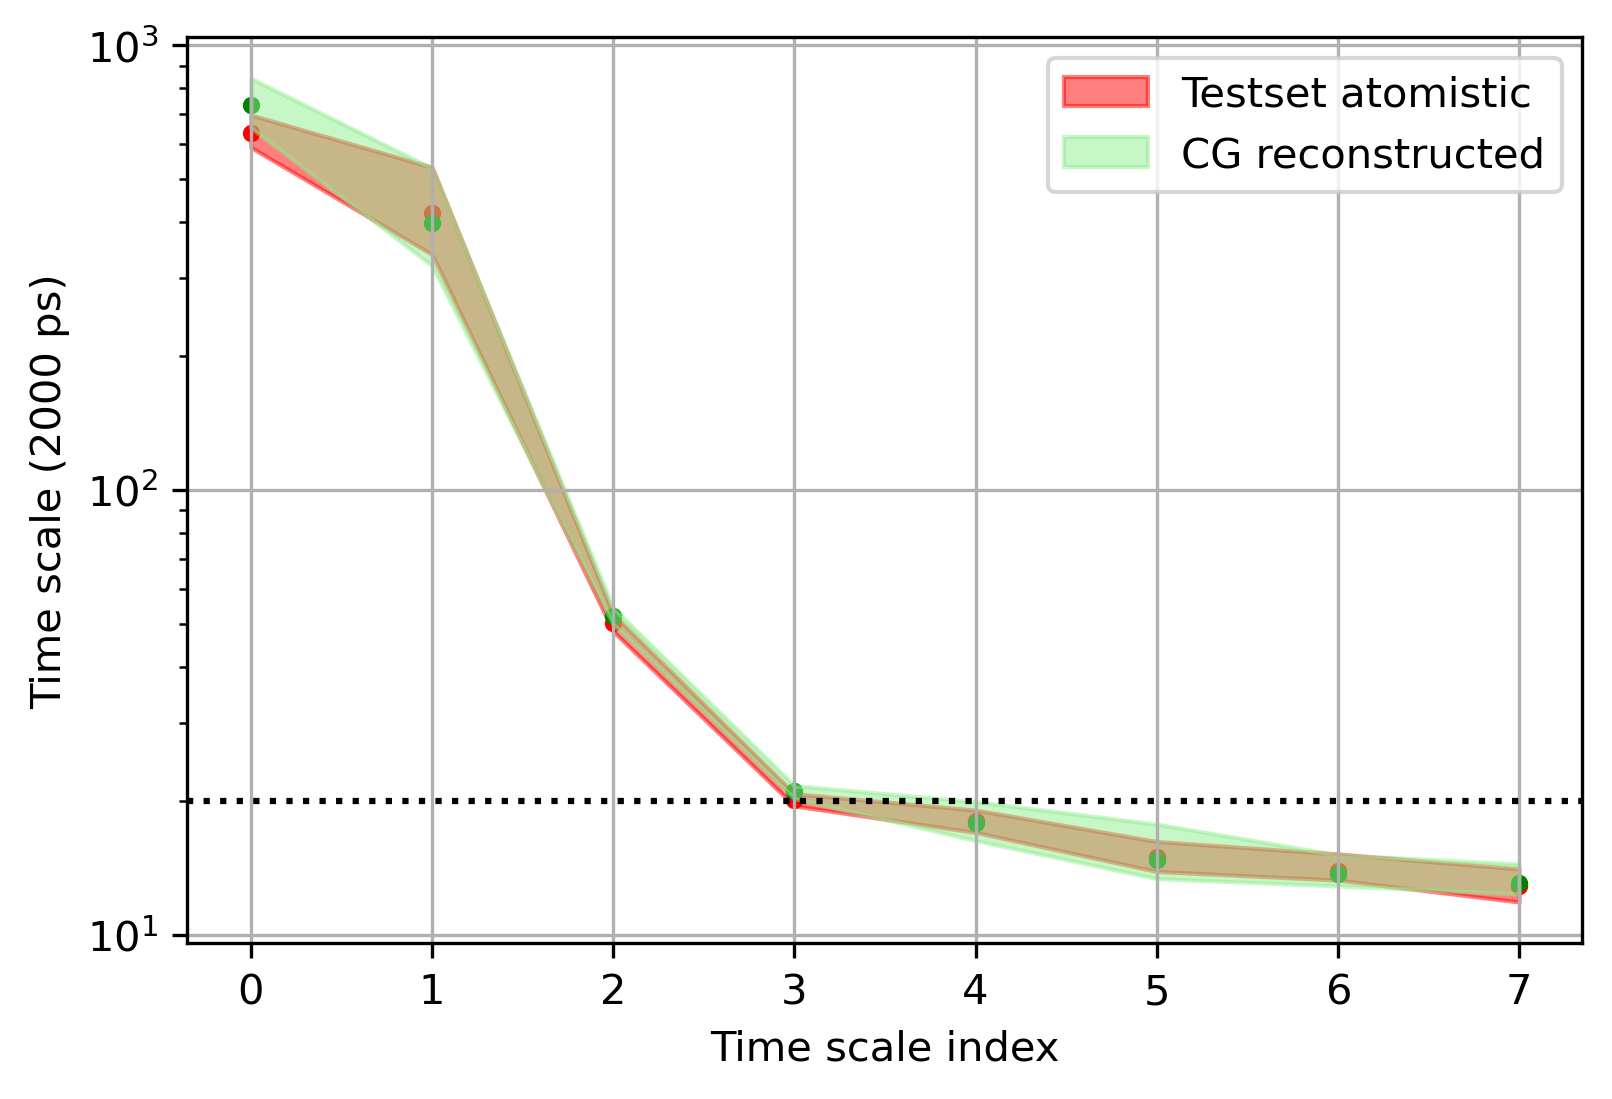

In [36]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Testset atomistic')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='CG reconstructed')
plt.yscale('log')

plt.axhline(lagtime, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (2000 ps)')
plt.show()

In [38]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    scores.append(abs(1 - cosine(evec_real[:, ts][counts_sliding.state_symbols], evec_fake[:, ts])))    

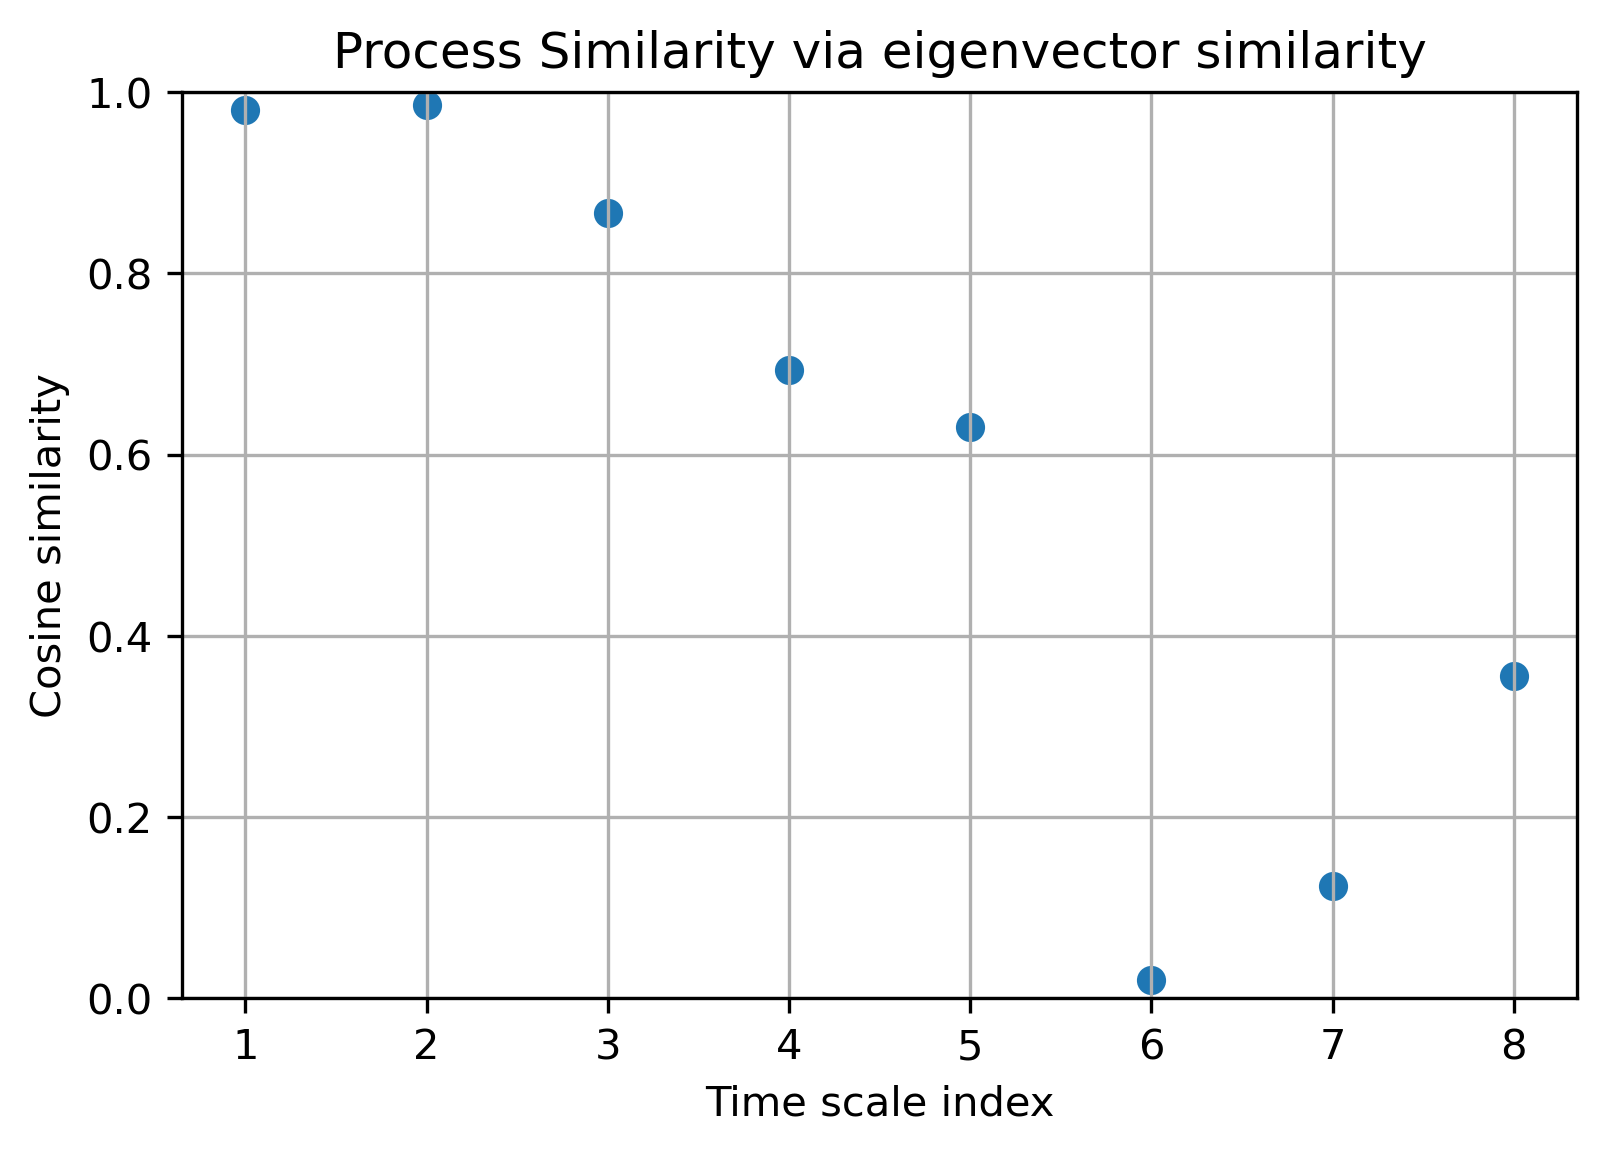

In [39]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via eigenvector similarity')
plt.ylim(0, 1)
plt.show()